In [60]:
from torch.utils.data import Dataset
class ParallelLanguageDataset(Dataset):
    def __init__(self, data_path_1, data_path_2, tokenizer, max_len):
        self.data_1, self.data_2 = self.load_data(data_path_1, data_path_2)
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data_1)

    def __getitem__(self, item_idx):
        sent1 = str(self.data_1[item_idx])
        sent2 = str(self.data_2[item_idx])
        encoded_output_sent1 = self.tokenizer.encode_plus(
            sent1,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt",
            truncation=True
        )
        encoded_output_sent2 = self.tokenizer.encode_plus(
            sent2,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt",
            truncation=True
        )

        encoded_output_sent1["attention_mask"][
            encoded_output_sent1["attention_mask"] == 1
        ] = 2
        encoded_output_sent1["attention_mask"][
            encoded_output_sent1["attention_mask"] == 0
        ] = True
        encoded_output_sent1["attention_mask"][
            encoded_output_sent1["attention_mask"] == 2
        ] = False
        encoded_output_sent1["attention_mask"] = encoded_output_sent1[
            "attention_mask"
        ].type(torch.bool)

        encoded_output_sent2["attention_mask"][
            encoded_output_sent2["attention_mask"] == 1
        ] = 2
        encoded_output_sent2["attention_mask"][
            encoded_output_sent2["attention_mask"] == 0
        ] = True
        encoded_output_sent2["attention_mask"][
            encoded_output_sent2["attention_mask"] == 2
        ] = False
        encoded_output_sent2["attention_mask"] = encoded_output_sent2[
            "attention_mask"
        ].type(torch.bool)

        return_dict = {
            "ids1": encoded_output_sent1["input_ids"].flatten(),
            "ids2": encoded_output_sent2["input_ids"].flatten(),
            "masks_sent1": encoded_output_sent1["attention_mask"].flatten(),
            "masks_sent2": encoded_output_sent2["attention_mask"].flatten(),
        }
        return return_dict

    def load_data(self, data_path_1, data_path_2):
        with open(data_path_1, "r") as f:
            data_1 = f.read().splitlines()[1:200]
        with open(data_path_2, "r") as f:
            data_2 = f.read().splitlines()[1:200]
        return data_1, data_2


In [61]:
!pip install einops

In [62]:
import math
from einops import rearrange

import torch
from torch import nn


class LanguageTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        max_seq_length,
        pos_dropout,
        trans_dropout,
    ):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Embedding(vocab_size, d_model)
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(
            d_model,
            nhead,
            num_encoder_layers,
            num_decoder_layers,
            dim_feedforward,
            trans_dropout,
        )
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(
        self,
        src,
        tgt,
        src_key_padding_mask,
        tgt_key_padding_mask,
        memory_key_padding_mask,
        tgt_mask,
    ):
        src = rearrange(src, "n s -> s n")
        tgt = rearrange(tgt, "n t -> t n")
        src = self.pos_enc(self.embed_src(src) * math.sqrt(self.d_model))
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        output = self.transformer(
            src,
            tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask,
        )
        output = rearrange(output, "t n e -> n t e")
        return self.fc(output)


# Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
cd /content/drive/MyDrive/Data/

/content/drive/MyDrive/Data


In [65]:
'''A wrapper class for optimizer '''
import numpy as np


# From https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Optim.py
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr
            

In [66]:
!pip install transformers

In [67]:
def train(train_loader, valid_loader, model, optim, criterion, num_epochs):
    print_every = 5
    model.train()

    lowest_val = 1e9
    train_losses = []
    val_losses = []
    total_step = 0
    print("-" * 100)
    print("Starting Training")
    print("-" * 100)

    for epoch in range(num_epochs):
        pbar = tqdm(total=print_every, leave=False)
        total_loss = 0
        train_loss = 0

        for step, data_dict in enumerate(iter(train_loader)):
            total_step += 1
            src, tgt, src_key_padding_mask, tgt_key_padding_mask = (
                data_dict["ids1"],
                data_dict["ids2"],
                data_dict["masks_sent1"],
                data_dict["masks_sent2"],
            )
            src, src_key_padding_mask = src.to("cuda"), src_key_padding_mask.to("cuda")
            tgt, tgt_key_padding_mask = tgt.to("cuda"), tgt_key_padding_mask.to("cuda")

            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to("cuda")

            optim.zero_grad()
            outputs = model(
                src,
                tgt_inp,
                src_key_padding_mask,
                tgt_key_padding_mask[:, :-1],
                memory_key_padding_mask,
                tgt_mask,
            )
            loss = criterion(
                rearrange(outputs, "b t v -> (b t) v"),
                rearrange(tgt_out, "b o -> (b o)"),
            )

            loss.backward()
            optim.step_and_update_lr()
            train_loss += loss.item()
            total_loss += loss.item()
            # train_losses.append((step, loss.item()))
            pbar.update(1)
            if step % print_every == print_every - 1:
                pbar.close()
                print(
                    f"Epoch [{epoch + 1} / {num_epochs}] \t Step [{step + 1} / {len(train_loader)}] \t "
                    f"Train Loss: {total_loss / print_every}"
                )
                total_loss = 0
                pbar = tqdm(total=print_every, leave=False)
        pbar.close()
        val_loss = validate(valid_loader, model, criterion)
        val_losses.append(val_loss)
        train_losses.append(train_loss/len(train_loader))
        if val_loss < lowest_val:
            lowest_val = val_loss
            torch.save(model, "Output/transformer.pth")
        print(f"Val Loss: {val_loss}")
    return train_losses, val_losses

In [68]:
def validate(valid_loader, model, criterion):
    pbar = tqdm(total=len(iter(valid_loader)), leave=False)
    model.eval()

    total_loss = 0
    for step, data_dict in enumerate(iter(valid_loader)):
        with torch.no_grad():
            src, tgt, src_key_padding_mask, tgt_key_padding_mask = (
                data_dict["ids1"],
                data_dict["ids2"],
                data_dict["masks_sent1"],
                data_dict["masks_sent2"],
            )
            src, src_key_padding_mask = src.to("cuda"), src_key_padding_mask.to("cuda")
            tgt, tgt_key_padding_mask = tgt.to("cuda"), tgt_key_padding_mask.to("cuda")
            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp = tgt[:, :-1]
            tgt_out = tgt[:, 1:].contiguous()
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to("cuda")
            outputs = model(
                src,
                tgt_inp,
                src_key_padding_mask,
                tgt_key_padding_mask[:, :-1],
                memory_key_padding_mask,
                tgt_mask,
            )
            loss = criterion(
                rearrange(outputs, "b t v -> (b t) v"),
                rearrange(tgt_out, "b o -> (b o)"),
            )
            total_loss += loss.item()
            pbar.update(1)

    pbar.close()
    model.train()
    return total_loss / len(valid_loader)


In [69]:
def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, "h w -> w h")
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask


In [70]:
import numpy as np
import torch
import torch.nn as nn
import transformers
from pathlib import Path
from einops import rearrange
from tqdm import tqdm
from transformers import RobertaTokenizer
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import logging
logging.basicConfig(level=logging.ERROR)

num_epochs = 20
batch_size = 8
max_seq_length = 96
d_model = 512
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
nhead = 8
pos_dropout = 0.1
trans_dropout = 0.1
n_warmup_steps = 2000
PRE_TRAINED_MODEL_NAME = "distilroberta-base"

train_losses = []
val_losses = []

In [71]:

project_path = ""
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
train_dataset = ParallelLanguageDataset(
        project_path + "raw/es/train.txt",
        project_path + "raw/en/train.txt",
        tokenizer,
        max_seq_length,
)
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
valid_dataset = ParallelLanguageDataset(
        project_path + "raw/es/val.txt",
        project_path + "raw/en/val.txt",
        tokenizer,
        max_seq_length,
    )
valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

model = LanguageTransformer(
        tokenizer.vocab_size,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        max_seq_length,
        pos_dropout,
        trans_dropout,
  ).to("cuda")
for p in model.parameters():
  if p.dim() > 1:
    nn.init.xavier_normal_(p)

optim = ScheduledOptim(Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09), d_model, n_warmup_steps)
criterion = nn.CrossEntropyLoss(ignore_index=0)
train_losses, val_losses = train(
      train_loader, valid_loader, model, optim, criterion, num_epochs
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



  0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Starting Training
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [1 / 30] 	 Step [5 / 25] 	 Train Loss: 10.68599624633789





 40%|████      | 2/5 [00:00<00:00,  5.68it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.70it/s]


100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.87it/s]

Epoch [1 / 30] 	 Step [10 / 25] 	 Train Loss: 10.469682693481445





 40%|████      | 2/5 [00:00<00:00,  5.81it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.73it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.73it/s]


100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.06it/s]

Epoch [1 / 30] 	 Step [15 / 25] 	 Train Loss: 10.191908645629884





 40%|████      | 2/5 [00:00<00:00,  5.95it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.89it/s]


100%|██████████| 5/5 [00:00<00:00,  5.87it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.88it/s]

Epoch [1 / 30] 	 Step [20 / 25] 	 Train Loss: 9.875433540344238





 40%|████      | 2/5 [00:00<00:00,  5.83it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.76it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.78it/s]


100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [1 / 30] 	 Step [25 / 25] 	 Train Loss: 9.808604049682618


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

Val Loss: 9.517433280944823


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [2 / 30] 	 Step [5 / 25] 	 Train Loss: 9.451534652709961





 40%|████      | 2/5 [00:00<00:00,  5.73it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.75it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.85it/s]


100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Epoch [2 / 30] 	 Step [10 / 25] 	 Train Loss: 9.2943359375





 40%|████      | 2/5 [00:00<00:00,  5.41it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.52it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.57it/s]


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.63it/s]

Epoch [2 / 30] 	 Step [15 / 25] 	 Train Loss: 9.343553161621093





 40%|████      | 2/5 [00:00<00:00,  5.83it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.76it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.74it/s]


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.68it/s]

Epoch [2 / 30] 	 Step [20 / 25] 	 Train Loss: 9.029743957519532





 40%|████      | 2/5 [00:00<00:00,  5.72it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.73it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.72it/s]


100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [2 / 30] 	 Step [25 / 25] 	 Train Loss: 8.98768367767334


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 8.962870979309082


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [3 / 30] 	 Step [5 / 25] 	 Train Loss: 8.801809692382813





 40%|████      | 2/5 [00:00<00:00,  5.48it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.46it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.53it/s]


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.79it/s]

Epoch [3 / 30] 	 Step [10 / 25] 	 Train Loss: 8.778602600097656





 40%|████      | 2/5 [00:00<00:00,  5.69it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.72it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.71it/s]


100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.87it/s]

Epoch [3 / 30] 	 Step [15 / 25] 	 Train Loss: 8.699011993408202





 40%|████      | 2/5 [00:00<00:00,  5.72it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.77it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.79it/s]


100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.91it/s]

Epoch [3 / 30] 	 Step [20 / 25] 	 Train Loss: 8.699715042114258





 40%|████      | 2/5 [00:00<00:00,  5.87it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.87it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.89it/s]


100%|██████████| 5/5 [00:00<00:00,  5.92it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [3 / 30] 	 Step [25 / 25] 	 Train Loss: 8.214697933197021


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 8.367808494567871


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [4 / 30] 	 Step [5 / 25] 	 Train Loss: 8.29446496963501





 40%|████      | 2/5 [00:00<00:00,  5.77it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.75it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.79it/s]


100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Epoch [4 / 30] 	 Step [10 / 25] 	 Train Loss: 8.25817937850952





 40%|████      | 2/5 [00:00<00:00,  5.34it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.44it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.53it/s]


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.83it/s]

Epoch [4 / 30] 	 Step [15 / 25] 	 Train Loss: 7.663263320922852





 40%|████      | 2/5 [00:00<00:00,  5.75it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.76it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.81it/s]


100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.84it/s]

Epoch [4 / 30] 	 Step [20 / 25] 	 Train Loss: 7.677864742279053





 40%|████      | 2/5 [00:00<00:00,  5.87it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.82it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.83it/s]


100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [4 / 30] 	 Step [25 / 25] 	 Train Loss: 7.509585285186768


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 7.5112752342224125


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [5 / 30] 	 Step [5 / 25] 	 Train Loss: 7.412296867370605





 40%|████      | 2/5 [00:00<00:00,  5.61it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.65it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.64it/s]


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Epoch [5 / 30] 	 Step [10 / 25] 	 Train Loss: 7.093937492370605





 40%|████      | 2/5 [00:00<00:00,  5.41it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.38it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.53it/s]


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.93it/s]

Epoch [5 / 30] 	 Step [15 / 25] 	 Train Loss: 7.082753276824951





 40%|████      | 2/5 [00:00<00:00,  5.82it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.84it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.87it/s]


100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.98it/s]

Epoch [5 / 30] 	 Step [20 / 25] 	 Train Loss: 6.464455509185791





 40%|████      | 2/5 [00:00<00:00,  5.91it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.88it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.87it/s]


100%|██████████| 5/5 [00:00<00:00,  5.91it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [5 / 30] 	 Step [25 / 25] 	 Train Loss: 6.2652593612670895


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 6.4469485855102535


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [6 / 30] 	 Step [5 / 25] 	 Train Loss: 6.226389217376709





 40%|████      | 2/5 [00:00<00:00,  5.90it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.87it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.82it/s]


100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.04it/s]

Epoch [6 / 30] 	 Step [10 / 25] 	 Train Loss: 6.039660167694092





 40%|████      | 2/5 [00:00<00:00,  5.86it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.75it/s]


100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.00it/s]

Epoch [6 / 30] 	 Step [15 / 25] 	 Train Loss: 5.66365327835083





 40%|████      | 2/5 [00:00<00:00,  5.83it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.85it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.88it/s]


100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.96it/s]

Epoch [6 / 30] 	 Step [20 / 25] 	 Train Loss: 5.3453185081481935





 40%|████      | 2/5 [00:00<00:00,  5.91it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.87it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.86it/s]


100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6 / 30] 	 Step [25 / 25] 	 Train Loss: 5.270661926269531





                                     /usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_lengt

Val Loss: 5.3805584144592284


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [7 / 30] 	 Step [5 / 25] 	 Train Loss: 4.876275062561035





 40%|████      | 2/5 [00:00<00:00,  5.63it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.58it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.56it/s]


100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.00it/s]

Epoch [7 / 30] 	 Step [10 / 25] 	 Train Loss: 4.775540542602539





 40%|████      | 2/5 [00:00<00:00,  5.88it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.78it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.82it/s]


100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.69it/s]

Epoch [7 / 30] 	 Step [15 / 25] 	 Train Loss: 4.784433841705322





 40%|████      | 2/5 [00:00<00:00,  5.60it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.68it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.71it/s]


100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.97it/s]

Epoch [7 / 30] 	 Step [20 / 25] 	 Train Loss: 4.339584159851074





 40%|████      | 2/5 [00:00<00:00,  5.98it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.98it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.91it/s]


100%|██████████| 5/5 [00:00<00:00,  5.98it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [7 / 30] 	 Step [25 / 25] 	 Train Loss: 4.48900671005249


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 4.563209838867188


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [8 / 30] 	 Step [5 / 25] 	 Train Loss: 4.117090129852295





 40%|████      | 2/5 [00:00<00:00,  5.74it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.67it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.70it/s]


100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.04it/s]

Epoch [8 / 30] 	 Step [10 / 25] 	 Train Loss: 3.8176300048828127





 40%|████      | 2/5 [00:00<00:00,  5.86it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.77it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.64it/s]


100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.65it/s]

Epoch [8 / 30] 	 Step [15 / 25] 	 Train Loss: 4.016630697250366





 40%|████      | 2/5 [00:00<00:00,  5.52it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.63it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.75it/s]


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.91it/s]

Epoch [8 / 30] 	 Step [20 / 25] 	 Train Loss: 3.5987485885620116





 40%|████      | 2/5 [00:00<00:00,  5.89it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.84it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.83it/s]


100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [8 / 30] 	 Step [25 / 25] 	 Train Loss: 4.0885828018188475


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 4.1339310359954835


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [9 / 30] 	 Step [5 / 25] 	 Train Loss: 3.4582923889160155





 40%|████      | 2/5 [00:00<00:00,  5.79it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.69it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.62it/s]


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.49it/s]

Epoch [9 / 30] 	 Step [10 / 25] 	 Train Loss: 3.5516398429870604





 40%|████      | 2/5 [00:00<00:00,  5.49it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.56it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.61it/s]


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.59it/s]

Epoch [9 / 30] 	 Step [15 / 25] 	 Train Loss: 3.4514130115509034





 40%|████      | 2/5 [00:00<00:00,  5.58it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.71it/s]


100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.09it/s]

Epoch [9 / 30] 	 Step [20 / 25] 	 Train Loss: 3.442330741882324





 40%|████      | 2/5 [00:00<00:00,  5.96it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.93it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.86it/s]


100%|██████████| 5/5 [00:00<00:00,  5.91it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [9 / 30] 	 Step [25 / 25] 	 Train Loss: 3.590365934371948


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.794139289855957


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [10 / 30] 	 Step [5 / 25] 	 Train Loss: 3.267364835739136





 40%|████      | 2/5 [00:00<00:00,  5.55it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.49it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.54it/s]


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.94it/s]

Epoch [10 / 30] 	 Step [10 / 25] 	 Train Loss: 3.6003896236419677





 40%|████      | 2/5 [00:00<00:00,  5.93it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.84it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.71it/s]


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.76it/s]

Epoch [10 / 30] 	 Step [15 / 25] 	 Train Loss: 3.2335607528686525





 40%|████      | 2/5 [00:00<00:00,  5.59it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.64it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.65it/s]


100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.93it/s]

Epoch [10 / 30] 	 Step [20 / 25] 	 Train Loss: 3.0504252433776857





 40%|████      | 2/5 [00:00<00:00,  5.88it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.84it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.80it/s]


100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [10 / 30] 	 Step [25 / 25] 	 Train Loss: 2.9193382978439333


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.6221659564971924


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [11 / 30] 	 Step [5 / 25] 	 Train Loss: 3.071144676208496





 40%|████      | 2/5 [00:00<00:00,  5.34it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.44it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.50it/s]


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.75it/s]

Epoch [11 / 30] 	 Step [10 / 25] 	 Train Loss: 3.0142813444137575





 40%|████      | 2/5 [00:00<00:00,  5.66it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.55it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.57it/s]


100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Epoch [11 / 30] 	 Step [15 / 25] 	 Train Loss: 3.7246933937072755





 40%|████      | 2/5 [00:00<00:00,  5.48it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.54it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.61it/s]


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.82it/s]

Epoch [11 / 30] 	 Step [20 / 25] 	 Train Loss: 2.78753457069397





 40%|████      | 2/5 [00:00<00:00,  5.75it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.79it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.79it/s]


100%|██████████| 5/5 [00:00<00:00,  5.87it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [11 / 30] 	 Step [25 / 25] 	 Train Loss: 2.7819424867630005


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.542877268791199


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [12 / 30] 	 Step [5 / 25] 	 Train Loss: 2.9713515758514406





 40%|████      | 2/5 [00:00<00:00,  5.70it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.61it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.56it/s]


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.75it/s]

Epoch [12 / 30] 	 Step [10 / 25] 	 Train Loss: 3.0180198669433596





 40%|████      | 2/5 [00:00<00:00,  5.66it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.60it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.64it/s]


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.69it/s]

Epoch [12 / 30] 	 Step [15 / 25] 	 Train Loss: 3.2236479759216308





 40%|████      | 2/5 [00:00<00:00,  5.59it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.66it/s]


100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.60it/s]

Epoch [12 / 30] 	 Step [20 / 25] 	 Train Loss: 2.794866609573364





 40%|████      | 2/5 [00:00<00:00,  5.67it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.71it/s]


100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [12 / 30] 	 Step [25 / 25] 	 Train Loss: 2.960578441619873


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.506488733291626


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [13 / 30] 	 Step [5 / 25] 	 Train Loss: 2.7280697584152223


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]


 40%|████      | 2/5 [00:00<00:00,  5.29it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.37it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.52it/s]


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Epoch [13 / 30] 	 Step [10 / 25] 	 Train Loss: 3.23019118309021





 40%|████      | 2/5 [00:00<00:00,  5.25it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.32it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.47it/s]


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.58it/s]

Epoch [13 / 30] 	 Step [15 / 25] 	 Train Loss: 2.8590651512145997





 40%|████      | 2/5 [00:00<00:00,  5.58it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.62it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.70it/s]


100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.98it/s]

Epoch [13 / 30] 	 Step [20 / 25] 	 Train Loss: 3.1053718090057374





 40%|████      | 2/5 [00:00<00:00,  5.91it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.78it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.75it/s]


100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [13 / 30] 	 Step [25 / 25] 	 Train Loss: 2.7057403564453124


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.4827974128723143


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [14 / 30] 	 Step [5 / 25] 	 Train Loss: 2.410642147064209





 40%|████      | 2/5 [00:00<00:00,  5.63it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.55it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.59it/s]


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Epoch [14 / 30] 	 Step [10 / 25] 	 Train Loss: 3.114715003967285





 40%|████      | 2/5 [00:00<00:00,  5.36it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.44it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.41it/s]


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Epoch [14 / 30] 	 Step [15 / 25] 	 Train Loss: 3.2440606594085692





 40%|████      | 2/5 [00:00<00:00,  5.24it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.34it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.43it/s]


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.86it/s]

Epoch [14 / 30] 	 Step [20 / 25] 	 Train Loss: 2.6261588096618653





 40%|████      | 2/5 [00:00<00:00,  5.73it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.77it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.75it/s]


100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [14 / 30] 	 Step [25 / 25] 	 Train Loss: 3.0354193687438964


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.4281315994262695


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [15 / 30] 	 Step [5 / 25] 	 Train Loss: 2.773270916938782


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]


 40%|████      | 2/5 [00:00<00:00,  5.16it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.14it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.16it/s]


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15 / 30] 	 Step [10 / 25] 	 Train Loss: 2.754742908477783





 20%|██        | 1/5 [00:00<00:00,  5.41it/s]


 40%|████      | 2/5 [00:00<00:00,  5.23it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.13it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.08it/s]


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15 / 30] 	 Step [15 / 25] 	 Train Loss: 3.0900034427642824





 20%|██        | 1/5 [00:00<00:00,  5.08it/s]


 40%|████      | 2/5 [00:00<00:00,  5.16it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.28it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.32it/s]


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Epoch [15 / 30] 	 Step [20 / 25] 	 Train Loss: 2.7065519094467163





 40%|████      | 2/5 [00:00<00:00,  5.44it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.47it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.49it/s]


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [15 / 30] 	 Step [25 / 25] 	 Train Loss: 2.7960651874542237


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.3902666664123533


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [16 / 30] 	 Step [5 / 25] 	 Train Loss: 2.7594011783599854





 40%|████      | 2/5 [00:00<00:00,  5.78it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.74it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.80it/s]


100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.99it/s]

Epoch [16 / 30] 	 Step [10 / 25] 	 Train Loss: 2.7939318895339964





 40%|████      | 2/5 [00:00<00:00,  5.37it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.39it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.40it/s]


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.82it/s]

Epoch [16 / 30] 	 Step [15 / 25] 	 Train Loss: 2.4094712495803834





 40%|████      | 2/5 [00:00<00:00,  5.63it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.64it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.63it/s]


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.79it/s]

Epoch [16 / 30] 	 Step [20 / 25] 	 Train Loss: 2.8484142780303956





 40%|████      | 2/5 [00:00<00:00,  5.74it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.77it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.83it/s]


100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [16 / 30] 	 Step [25 / 25] 	 Train Loss: 2.942714786529541


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.3399026679992674


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [17 / 30] 	 Step [5 / 25] 	 Train Loss: 2.9921896934509276





 40%|████      | 2/5 [00:00<00:00,  5.42it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.36it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.37it/s]


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Epoch [17 / 30] 	 Step [10 / 25] 	 Train Loss: 2.3470563173294066





 40%|████      | 2/5 [00:00<00:00,  5.20it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.27it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.35it/s]


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Epoch [17 / 30] 	 Step [15 / 25] 	 Train Loss: 2.5557615756988525





 40%|████      | 2/5 [00:00<00:00,  5.41it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.47it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.50it/s]


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.92it/s]

Epoch [17 / 30] 	 Step [20 / 25] 	 Train Loss: 2.302156352996826





 40%|████      | 2/5 [00:00<00:00,  5.85it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.94it/s]


100%|██████████| 5/5 [00:00<00:00,  5.91it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [17 / 30] 	 Step [25 / 25] 	 Train Loss: 3.1065918445587157


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.288944597244263


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [18 / 30] 	 Step [5 / 25] 	 Train Loss: 2.5757070541381837





 40%|████      | 2/5 [00:00<00:00,  5.46it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.48it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.47it/s]


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18 / 30] 	 Step [10 / 25] 	 Train Loss: 2.891794776916504





 20%|██        | 1/5 [00:00<00:00,  5.26it/s]


 40%|████      | 2/5 [00:00<00:00,  5.44it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.56it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.50it/s]


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.58it/s]

Epoch [18 / 30] 	 Step [15 / 25] 	 Train Loss: 2.119794821739197





 40%|████      | 2/5 [00:00<00:00,  5.44it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.43it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.53it/s]


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.87it/s]

Epoch [18 / 30] 	 Step [20 / 25] 	 Train Loss: 2.583682727813721





 40%|████      | 2/5 [00:00<00:00,  5.73it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.77it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.72it/s]


100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [18 / 30] 	 Step [25 / 25] 	 Train Loss: 2.6015799045562744


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.23463903427124


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [19 / 30] 	 Step [5 / 25] 	 Train Loss: 2.2382635354995726





 40%|████      | 2/5 [00:00<00:00,  5.47it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.46it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.47it/s]


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.47it/s]

Epoch [19 / 30] 	 Step [10 / 25] 	 Train Loss: 2.523200750350952





 40%|████      | 2/5 [00:00<00:00,  5.53it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.50it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.50it/s]


100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Epoch [19 / 30] 	 Step [15 / 25] 	 Train Loss: 2.47236430644989





 40%|████      | 2/5 [00:00<00:00,  5.30it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.48it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.56it/s]


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.06it/s]

Epoch [19 / 30] 	 Step [20 / 25] 	 Train Loss: 2.2783625602722166





 40%|████      | 2/5 [00:00<00:00,  5.94it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.86it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.80it/s]


100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [19 / 30] 	 Step [25 / 25] 	 Train Loss: 2.6090713024139403


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.177771487236023


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [20 / 30] 	 Step [5 / 25] 	 Train Loss: 2.5708303928375242





 40%|████      | 2/5 [00:00<00:00,  5.36it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.38it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.41it/s]


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.05it/s]

Epoch [20 / 30] 	 Step [10 / 25] 	 Train Loss: 2.386309027671814





 40%|████      | 2/5 [00:00<00:00,  5.89it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.73it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.65it/s]


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]




Epoch [20 / 30] 	 Step [15 / 25] 	 Train Loss: 1.9761330127716064


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]


 40%|████      | 2/5 [00:00<00:00,  5.17it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.31it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.45it/s]


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.87it/s]

Epoch [20 / 30] 	 Step [20 / 25] 	 Train Loss: 2.4089226007461546





 40%|████      | 2/5 [00:00<00:00,  5.80it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.80it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.81it/s]


100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [20 / 30] 	 Step [25 / 25] 	 Train Loss: 2.098223853111267


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.1108292531967163


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [21 / 30] 	 Step [5 / 25] 	 Train Loss: 2.271582078933716





 40%|████      | 2/5 [00:00<00:00,  5.54it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.51it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.51it/s]


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

Epoch [21 / 30] 	 Step [10 / 25] 	 Train Loss: 2.3536291122436523





 40%|████      | 2/5 [00:00<00:00,  5.52it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.51it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.42it/s]


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.91it/s]

Epoch [21 / 30] 	 Step [15 / 25] 	 Train Loss: 2.147092652320862





 40%|████      | 2/5 [00:00<00:00,  5.37it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.40it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.42it/s]


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.60it/s]

Epoch [21 / 30] 	 Step [20 / 25] 	 Train Loss: 1.8639814138412476





 40%|████      | 2/5 [00:00<00:00,  5.31it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.36it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.44it/s]


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [21 / 30] 	 Step [25 / 25] 	 Train Loss: 2.2050825119018556


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.100318078994751


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [22 / 30] 	 Step [5 / 25] 	 Train Loss: 2.201532316207886





 40%|████      | 2/5 [00:00<00:00,  5.48it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.43it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.43it/s]


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [22 / 30] 	 Step [10 / 25] 	 Train Loss: 2.0687973260879517





 20%|██        | 1/5 [00:00<00:00,  5.15it/s]


 40%|████      | 2/5 [00:00<00:00,  5.24it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.38it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.44it/s]


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Epoch [22 / 30] 	 Step [15 / 25] 	 Train Loss: 2.336742305755615





 40%|████      | 2/5 [00:00<00:00,  5.24it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.33it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.47it/s]


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.00it/s]

Epoch [22 / 30] 	 Step [20 / 25] 	 Train Loss: 1.822064709663391





 40%|████      | 2/5 [00:00<00:00,  5.92it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.86it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.80it/s]


100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [22 / 30] 	 Step [25 / 25] 	 Train Loss: 1.9058581113815307


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.0862687683105468


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [23 / 30] 	 Step [5 / 25] 	 Train Loss: 2.126802659034729


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]


 40%|████      | 2/5 [00:00<00:00,  5.31it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.45it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.51it/s]


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.64it/s]

Epoch [23 / 30] 	 Step [10 / 25] 	 Train Loss: 1.8066803693771363





 40%|████      | 2/5 [00:00<00:00,  5.50it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.43it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.51it/s]


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Epoch [23 / 30] 	 Step [15 / 25] 	 Train Loss: 1.8298020482063293





 40%|████      | 2/5 [00:00<00:00,  5.37it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.42it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.52it/s]


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  6.02it/s]

Epoch [23 / 30] 	 Step [20 / 25] 	 Train Loss: 1.9738752365112304





 40%|████      | 2/5 [00:00<00:00,  5.86it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.79it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.72it/s]


100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [23 / 30] 	 Step [25 / 25] 	 Train Loss: 2.044087862968445


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.0321297788619996


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [24 / 30] 	 Step [5 / 25] 	 Train Loss: 1.8956607103347778





 40%|████      | 2/5 [00:00<00:00,  5.43it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.57it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.41it/s]


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.76it/s]

Epoch [24 / 30] 	 Step [10 / 25] 	 Train Loss: 1.652863621711731





 40%|████      | 2/5 [00:00<00:00,  5.56it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.64it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.62it/s]


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Epoch [24 / 30] 	 Step [15 / 25] 	 Train Loss: 1.7465685606002808





 40%|████      | 2/5 [00:00<00:00,  5.39it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.54it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.55it/s]


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.63it/s]

Epoch [24 / 30] 	 Step [20 / 25] 	 Train Loss: 2.092726993560791





 40%|████      | 2/5 [00:00<00:00,  5.63it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.58it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.72it/s]


100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [24 / 30] 	 Step [25 / 25] 	 Train Loss: 1.8242928028106689


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.0275968980789183


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [25 / 30] 	 Step [5 / 25] 	 Train Loss: 1.7336055517196656





 20%|██        | 1/5 [00:00<00:00,  5.00it/s]


 40%|████      | 2/5 [00:00<00:00,  5.07it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.09it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.12it/s]


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [25 / 30] 	 Step [10 / 25] 	 Train Loss: 1.6490951299667358





 20%|██        | 1/5 [00:00<00:00,  4.90it/s]


 40%|████      | 2/5 [00:00<00:00,  5.01it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.15it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.35it/s]


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.54it/s]

Epoch [25 / 30] 	 Step [15 / 25] 	 Train Loss: 2.031808042526245





 40%|████      | 2/5 [00:00<00:00,  5.63it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.67it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.74it/s]


100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.75it/s]

Epoch [25 / 30] 	 Step [20 / 25] 	 Train Loss: 1.8268418788909913





 40%|████      | 2/5 [00:00<00:00,  5.65it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.61it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.61it/s]


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [25 / 30] 	 Step [25 / 25] 	 Train Loss: 1.4572893857955933


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.0410311365127565


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [26 / 30] 	 Step [5 / 25] 	 Train Loss: 1.6956332683563233





 20%|██        | 1/5 [00:00<00:00,  4.65it/s]


 40%|████      | 2/5 [00:00<00:00,  4.70it/s]


 60%|██████    | 3/5 [00:00<00:00,  4.71it/s]


 80%|████████  | 4/5 [00:00<00:00,  4.64it/s]


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26 / 30] 	 Step [10 / 25] 	 Train Loss: 1.4325454831123352





 20%|██        | 1/5 [00:00<00:00,  4.90it/s]


 40%|████      | 2/5 [00:00<00:00,  4.93it/s]


 60%|██████    | 3/5 [00:00<00:00,  4.90it/s]


 80%|████████  | 4/5 [00:00<00:00,  4.89it/s]


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26 / 30] 	 Step [15 / 25] 	 Train Loss: 1.8153404951095582





 20%|██        | 1/5 [00:00<00:01,  3.97it/s]


 40%|████      | 2/5 [00:00<00:00,  4.22it/s]


 60%|██████    | 3/5 [00:00<00:00,  4.50it/s]


 80%|████████  | 4/5 [00:00<00:00,  4.69it/s]


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26 / 30] 	 Step [20 / 25] 	 Train Loss: 1.6442843198776245





 20%|██        | 1/5 [00:00<00:00,  4.92it/s]


 40%|████      | 2/5 [00:00<00:00,  4.98it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.02it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.18it/s]


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [26 / 30] 	 Step [25 / 25] 	 Train Loss: 1.6934292793273926


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.0493170022964478


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [27 / 30] 	 Step [5 / 25] 	 Train Loss: 1.24499169588089





 40%|████      | 2/5 [00:00<00:00,  5.32it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.35it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.33it/s]


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [27 / 30] 	 Step [10 / 25] 	 Train Loss: 1.469376540184021





 20%|██        | 1/5 [00:00<00:00,  5.11it/s]


 40%|████      | 2/5 [00:00<00:00,  5.08it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.19it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.28it/s]


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [27 / 30] 	 Step [15 / 25] 	 Train Loss: 1.6491044998168944





 20%|██        | 1/5 [00:00<00:00,  5.20it/s]


 40%|████      | 2/5 [00:00<00:00,  5.19it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.31it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.40it/s]


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.96it/s]

Epoch [27 / 30] 	 Step [20 / 25] 	 Train Loss: 1.8960464715957641





 40%|████      | 2/5 [00:00<00:00,  5.95it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.81it/s]


100%|██████████| 5/5 [00:00<00:00,  5.87it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [27 / 30] 	 Step [25 / 25] 	 Train Loss: 1.475495743751526


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.061821928024292


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [28 / 30] 	 Step [5 / 25] 	 Train Loss: 1.5232759475708009





 20%|██        | 1/5 [00:00<00:00,  5.00it/s]


 40%|████      | 2/5 [00:00<00:00,  5.17it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.31it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.38it/s]


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.77it/s]

Epoch [28 / 30] 	 Step [10 / 25] 	 Train Loss: 1.2793728351593017





 40%|████      | 2/5 [00:00<00:00,  5.68it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.67it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.46it/s]


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [28 / 30] 	 Step [15 / 25] 	 Train Loss: 1.4875619888305665





 20%|██        | 1/5 [00:00<00:00,  4.99it/s]


 40%|████      | 2/5 [00:00<00:00,  5.24it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.39it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.45it/s]


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.86it/s]

Epoch [28 / 30] 	 Step [20 / 25] 	 Train Loss: 1.3128705263137816





 40%|████      | 2/5 [00:00<00:00,  5.86it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.75it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.70it/s]


100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [28 / 30] 	 Step [25 / 25] 	 Train Loss: 1.7189233541488647


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.0719117069244386


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [29 / 30] 	 Step [5 / 25] 	 Train Loss: 1.43756263256073





 40%|████      | 2/5 [00:00<00:00,  5.78it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.73it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.65it/s]


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.76it/s]

Epoch [29 / 30] 	 Step [10 / 25] 	 Train Loss: 1.3553614497184754





 40%|████      | 2/5 [00:00<00:00,  5.52it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.50it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.44it/s]


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Epoch [29 / 30] 	 Step [15 / 25] 	 Train Loss: 1.2672502160072328





 40%|████      | 2/5 [00:00<00:00,  5.40it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.49it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.55it/s]


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.87it/s]

Epoch [29 / 30] 	 Step [20 / 25] 	 Train Loss: 1.3683847069740296





 40%|████      | 2/5 [00:00<00:00,  5.89it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.80it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.78it/s]


100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [29 / 30] 	 Step [25 / 25] 	 Train Loss: 1.4717206239700318


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.122143516540527


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Epoch [30 / 30] 	 Step [5 / 25] 	 Train Loss: 1.1225677967071532





 40%|████      | 2/5 [00:00<00:00,  5.35it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.37it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.53it/s]


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Epoch [30 / 30] 	 Step [10 / 25] 	 Train Loss: 1.3153573274612427





 40%|████      | 2/5 [00:00<00:00,  5.47it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.54it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.48it/s]


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.82it/s]

Epoch [30 / 30] 	 Step [15 / 25] 	 Train Loss: 1.4281273126602172





 40%|████      | 2/5 [00:00<00:00,  5.77it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.74it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.71it/s]


100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:00,  5.80it/s]

Epoch [30 / 30] 	 Step [20 / 25] 	 Train Loss: 1.2505608201026917





 40%|████      | 2/5 [00:00<00:00,  5.70it/s]


 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]


 80%|████████  | 4/5 [00:00<00:00,  5.69it/s]


100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


                                             


  0%|          | 0/5 [00:00<?, ?it/s]


                                     

Epoch [30 / 30] 	 Step [25 / 25] 	 Train Loss: 1.266396450996399


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val Loss: 3.158693780899048


In [73]:
print(len(train_losses))
print(len(val_losses))

30
30


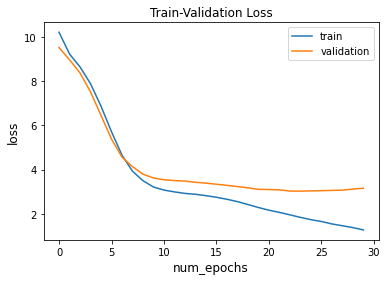

In [74]:
fig = plt.figure()
plt.title("Train-Validation Loss")
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')

plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
print()